<a href="https://colab.research.google.com/github/DavidCastroPena/keras-anomaly-autoencoder/blob/main/keras_anomaly_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import glob, cv2, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 64


In [24]:
!wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz -O /content/UCSD_Anomaly_Dataset.tar.gz


--2025-09-17 04:13:51--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘/content/UCSD_Anomaly_Dataset.tar.gz’

/content/UCSD_Anoma 100%[===================>] 706.01M   107MB/s    in 9.5s    

2025-09-17 04:14:00 (74.4 MB/s) - ‘/content/UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [25]:

!mkdir -p /content/UCSD_Anomaly_Dataset
!tar -xzf /content/UCSD_Anomaly_Dataset.tar.gz -C /content/UCSD_Anomaly_Dataset

In [26]:

!ls -R /content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2 | head -40



/content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2:
README.txt
README.txt~
UCSDped1
UCSDped2

/content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1:
Test
Train

/content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test:
Test001
Test002
Test003
Test003_gt
Test004
Test004_gt
Test005
Test006
Test007
Test008
Test009
Test010
Test011
Test012
Test013
Test014
Test014_gt
Test015
Test016
Test017
Test018
Test018_gt
Test019
Test019_gt
Test020
Test021
Test021_gt
Test022
Test022_gt


In [27]:
!ls /content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001 | head


001.tif
002.tif
003.tif
004.tif
005.tif
006.tif
007.tif
008.tif
009.tif
010.tif


In [28]:
def load_frame(path, resize=(IMG_SIZE, IMG_SIZE)):
    frame = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, resize)
    return frame.astype("float32") / 255.0


In [29]:
DATA_DIR = "/content/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2"

train_frames = sorted(glob.glob(DATA_DIR + "/Train/*/*.tif"))
test_frames  = sorted(glob.glob(DATA_DIR + "/Test/*/*.tif"))

print("Total training frames found:", len(train_frames))
print("Total test frames found:", len(test_frames))

# Collect *all* frames from Train and Test
train_frames = sorted(glob.glob(DATA_DIR + "/Train/*/*.tif"))
test_frames  = sorted(glob.glob(DATA_DIR + "/Test/*/*.tif"))

print("Total training frames found:", len(train_frames))
print("Total test frames found:", len(test_frames))


Total training frames found: 2550
Total test frames found: 2010
Total training frames found: 2550
Total test frames found: 2010


In [30]:
X_train = np.array([load_frame(f) for f in train_frames])
X_train = np.expand_dims(X_train, -1)

X_test = np.array([load_frame(f) for f in test_frames])
X_test = np.expand_dims(X_test, -1)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2550, 64, 64, 1)
Test shape: (2010, 64, 64, 1)


In [31]:
def build_deeper_autoencoder(img_size=64):
    input_img = layers.Input(shape=(img_size, img_size, 1))

    # Encoder
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2,2), padding="same")(x)

    # Decoder
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2,2))(x)

    decoded = layers.Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

    return models.Model(input_img, decoded)


In [32]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [33]:
autoencoder = build_deeper_autoencoder(img_size=IMG_SIZE)
autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    X_train, X_train,
    epochs=300,
    batch_size=5,
    validation_split=0.4,
    shuffle=True
)


Epoch 1/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0084 - val_loss: 0.0019
Epoch 2/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 9.6933e-04
Epoch 7/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0013 - val_loss: 9.6858e-04
Epoch 8/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013 - val_loss: 9.5633e-04
Epoch 9/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0012 - val_loss: 9.0071e-04
Epoch 10/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 8.5256e-04
Epoch 11/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 8.7464e-04
Epoch 12/300
306/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


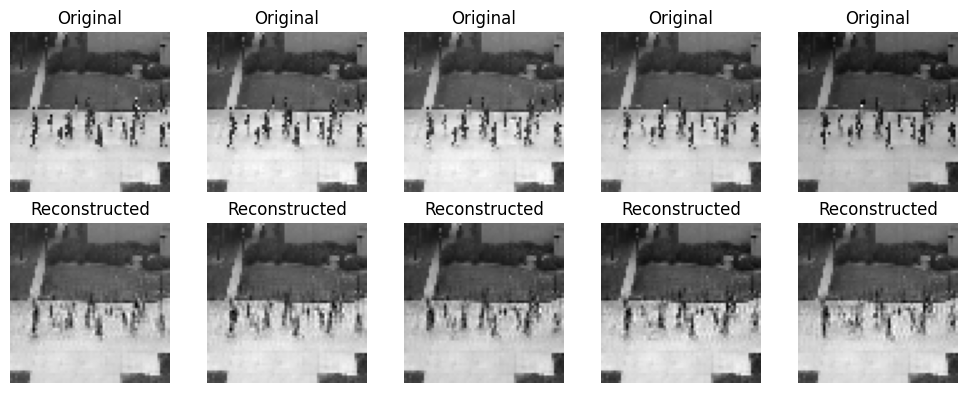

In [34]:
decoded_imgs = autoencoder.predict(X_test[:10])

import matplotlib.pyplot as plt

n = 5  # number of samples
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


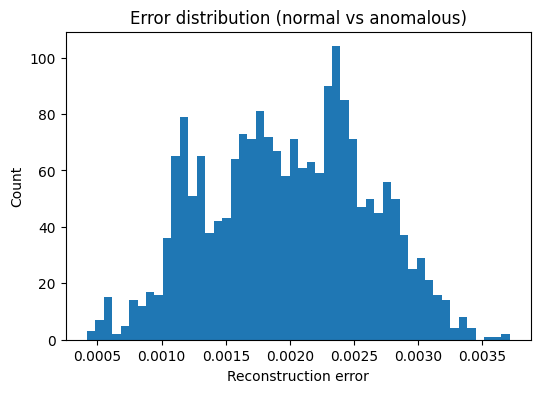

In [35]:
# Predict reconstruction for the whole test set
reconstructions = autoencoder.predict(X_test)

# Compute mean squared error per frame
errors = np.mean(np.square(X_test - reconstructions), axis=(1,2,3))

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(errors, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Error distribution (normal vs anomalous)")
plt.show()


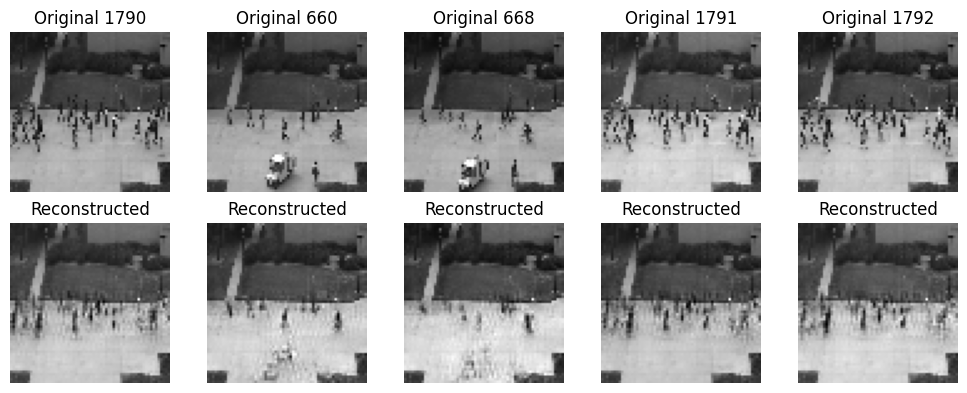

In [36]:
# Get indices of top 5 anomalous frames
idxs = errors.argsort()[-5:]

plt.figure(figsize=(10,4))
for i, idx in enumerate(idxs):
    # Original
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].reshape(64,64), cmap="gray")
    plt.title(f"Original {idx}")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, 5, i+6)
    plt.imshow(reconstructions[idx].reshape(64,64), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [37]:
import os, cv2, numpy as np
from pathlib import Path

# We already have:
# - DATA_DIR
# - test_frames  (your subset order)
# - reconstructions, errors, X_test   (from previous steps)

def gt_mask_path_for_frame(frame_path: str):
    """
    Given a frame path like:
      .../UCSDped2/Test/Test001/123.tif
    return the matching GT mask path, e.g.:
      .../UCSDped2/Test/Test001_gt/123.bmp (or .png/.tif)
    We try several common extensions.
    """
    p = Path(frame_path)
    gt_dir = p.parent.parent / f"{p.parent.name}_gt"  # Test001 -> Test001_gt
    stem = p.stem  # '123'
    for ext in (".bmp", ".png", ".tif"):
        cand = gt_dir / f"{stem}{ext}"
        if cand.exists():
            return str(cand)
    return None

y_true = []
valid_scores = []
valid_idxs = []

for i, f in enumerate(test_frames[:len(errors)]):   # align with computed errors
    mpath = gt_mask_path_for_frame(f)
    if mpath is None:
        # no GT mask found for this frame: skip
        continue
    mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    # Label 1 if there is any annotated anomalous pixel
    y_true.append(1 if (mask > 0).any() else 0)
    valid_scores.append(float(errors[i]))
    valid_idxs.append(i)

y_true = np.array(y_true)
valid_scores = np.array(valid_scores)
print("Frames with GT found:", len(y_true), " | Positives:", y_true.sum(), " | Negatives:", (y_true==0).sum())


Frames with GT found: 1530  | Positives: 1276  | Negatives: 254


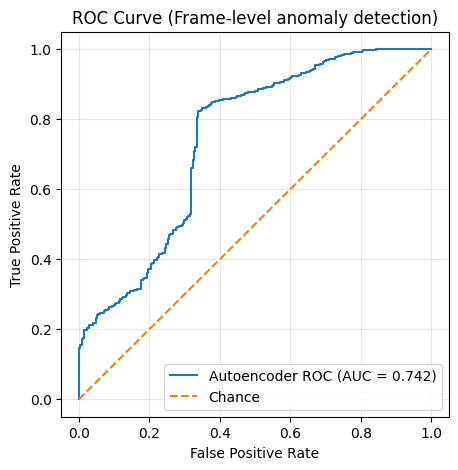

Suggested threshold by Youden J: 0.001468
At threshold 0.001468 → Acc: 0.796  Precision: 0.924  Recall: 0.823  F1: 0.871


In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if len(y_true) == 0:
    print("No ground-truth masks found for the sampled frames. "
          "Open one TestNNN folder and confirm there is a matching TestNNN_gt with masks.")
else:
    fpr, tpr, thr = roc_curve(y_true, valid_scores)  # scores = higher means more likely anomaly
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"Autoencoder ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Frame-level anomaly detection)")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Optional: pick a threshold at the Youden J statistic (max TPR-FPR)
    j = np.argmax(tpr - fpr)
    best_thr = thr[j]
    print(f"Suggested threshold by Youden J: {best_thr:.6f}")

    # Quick precision/recall at that threshold
    y_pred = (valid_scores >= best_thr).astype(int)
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    print(f"At threshold {best_thr:.6f} → Acc: {acc:.3f}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f1:.3f}")


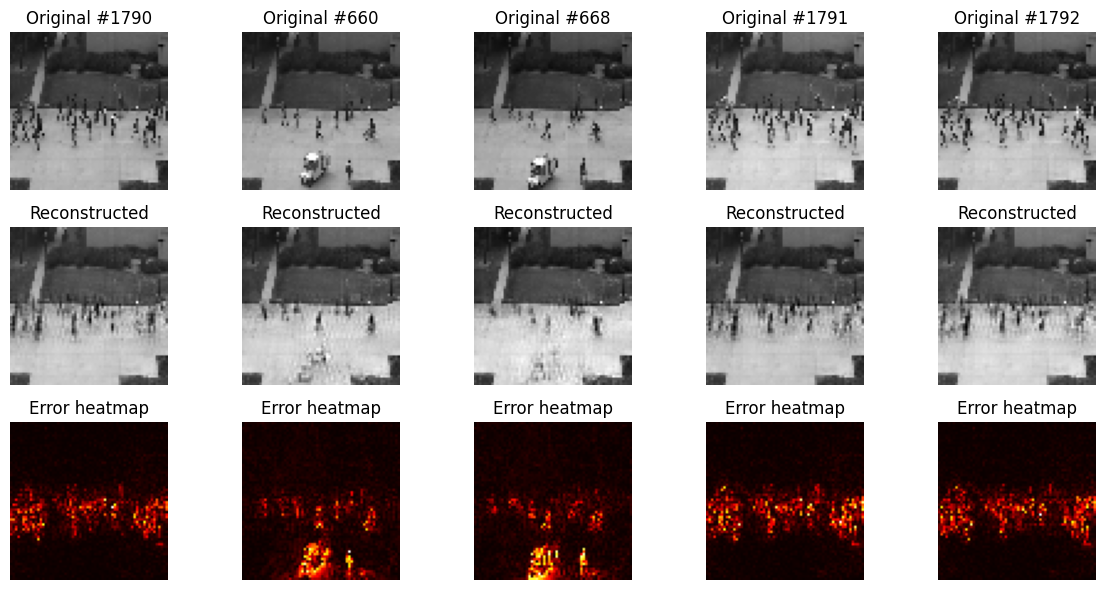

In [39]:
# Use the indices we kept (valid_idxs) to align errors/reconstructions with y_true
if len(y_true) > 0:
    topk = 5
    top_idx_in_valid = np.argsort(valid_scores)[-topk:]
    sel = [valid_idxs[i] for i in top_idx_in_valid]

    plt.figure(figsize=(12,6))
    for j, idx in enumerate(sel):
        err_map = np.abs(X_test[idx].squeeze() - reconstructions[idx].squeeze())

        ax = plt.subplot(3, topk, j+1)
        plt.imshow(X_test[idx].squeeze(), cmap="gray"); plt.title(f"Original #{idx}"); plt.axis("off")

        ax = plt.subplot(3, topk, j+1+topk)
        plt.imshow(reconstructions[idx].squeeze(), cmap="gray"); plt.title("Reconstructed"); plt.axis("off")

        ax = plt.subplot(3, topk, j+1+2*topk)
        plt.imshow(err_map, cmap="hot"); plt.title("Error heatmap"); plt.axis("off")

    plt.tight_layout(); plt.show()


In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score
prec, rec, thr = precision_recall_curve(y_true, valid_scores)
ap = average_precision_score(y_true, valid_scores)
print("Average Precision (AUPRC):", ap)


Average Precision (AUPRC): 0.9257286027787278


In [42]:
import numpy as np

target_alert_rate = 0.02  # e.g., alert on top 2% highest-score frames
thr_alert = np.quantile(valid_scores, 1 - target_alert_rate)
print("Threshold for ~2% alert rate:", thr_alert)


Threshold for ~2% alert rate: 0.0031929021887481214


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix

def pick_cost_opt_threshold(scores, y_true, costs=(10.0, 1.0)):  # (cost_FN, cost_FP)
    thr_grid = np.quantile(scores, np.linspace(0.0, 1.0, 200))
    best = None
    for t in thr_grid:
        yp = (scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        cost = costs[0]*fn + costs[1]*fp
        if best is None or cost < best[0]:
            best = (cost, t, (tn, fp, fn, tp))
    return best  # (min_cost, best_thr, confusion)

min_cost, t_star, cm = pick_cost_opt_threshold(valid_scores, y_true)
print(f"Best thr={t_star:.6f}  Min expected cost={min_cost}  Confusion={cm}")


Best thr=0.000742  Min expected cost=223.0  Confusion=(np.int64(31), np.int64(223), np.int64(0), np.int64(1276))
